<a href="https://colab.research.google.com/github/viniciostec22/Introducao_Redes_Neurais/blob/main/Introdu%C3%A7%C3%A3o_redeurais_convulacionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preparando Conjunto de dados

Conjunto de dados classico CIFAR10

In [70]:
import torch
import matplotlib.pyplot as plt
import os

from torchvision.datasets import CIFAR10

In [73]:
BASE_DIR = '/content/drive/MyDrive/datasets'
DATA_DIR = '/content/drive/MyDrive/datasets/cifar10'
CATEGORIES = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
def get_path(relpath):
  return os.path.join(BASE_DIR, relpath)

In [4]:
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

Vizualizando algumas imagens do conjuento de dados

In [6]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8, 8))
  rows, cols = 2, 2
  for i in range(1, 5):
      sample_idx = torch.randint(len(dataset), size=(1,)).item()
      img, label = dataset[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(CATEGORIES[label])
      plt.axis("off")
      if istensor:
        plt.imshow(img.squeeze().permute(1, 2, 0))
      else:
        plt.imshow(img)
  plt.show()

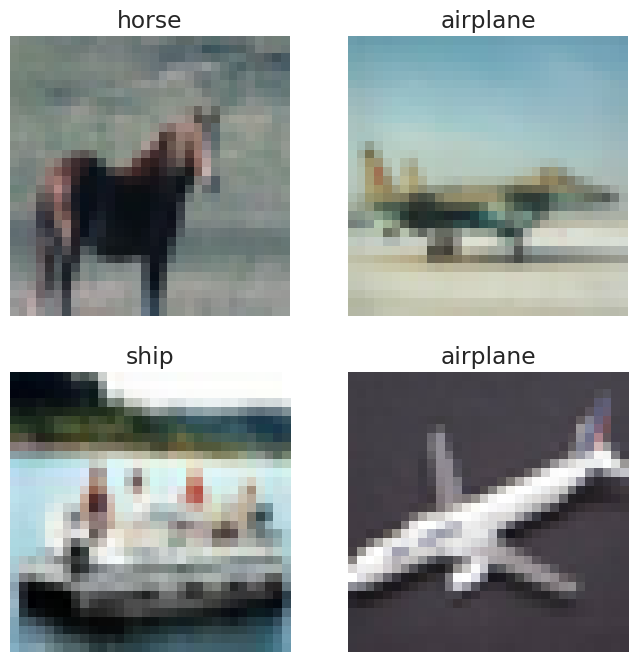

In [60]:
lookat_dataset(cifar10_train)

## Pre-processamento dos dados


In [7]:
import torchvision.transforms as T

In [8]:
prep_transform = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(
            (0.4914, 0.4822, 0.4465),
            (0.2470, 0.2435, 0.2616)
        )
    ]
)

tensor_train = CIFAR10(DATA_DIR, train=True, download=False, transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False, transform=prep_transform)

Obter valores de normalização

In [9]:
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [10]:
imgs.view(3, -1).mean(dim=1)

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [11]:
imgs.view(3, -1).std(dim=1)

tensor([1.0001, 0.9999, 1.0000])

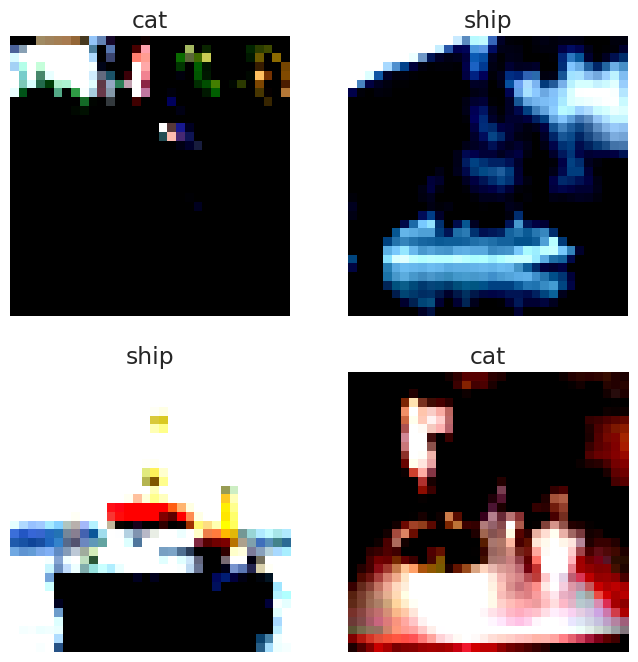

In [61]:
lookat_dataset(tensor_train, True)

#Criando Dataloaders

In [12]:
from torch.utils.data import DataLoader

In [13]:
batch_size = 64
train_loader = DataLoader(tensor_train,batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test ,batch_size=batch_size, shuffle=True)

## Construindo uma rede MLP

In [17]:
from torch import nn

In [18]:
class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()

    self.layers = nn.Sequential(
        nn.Linear(3 * 32*32, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )

  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

Rodando na cuda


In [19]:
model = MLPClassifier().to(device)

## Hiperparametros de de otimização

In [30]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [29]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)

    #zera os gradientes acumulados
    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)

In [49]:

def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize="16")
  ax.set_xlabel("Iteration", fontsize="16")
  ax.set_ylabel("Loss", fontsize="16")
  ax.set_title("Loss vs iterations", fontsize="16");

In [62]:
epochs = 31
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")

  test_loss = validate(model, test_loader, loss_func)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.296914626570309
Epoch: 10; Train Loss: 1.8067465179106768
Epoch: 20; Train Loss: 1.610298821688308
Epoch: 30; Train Loss: 1.4925301632917751


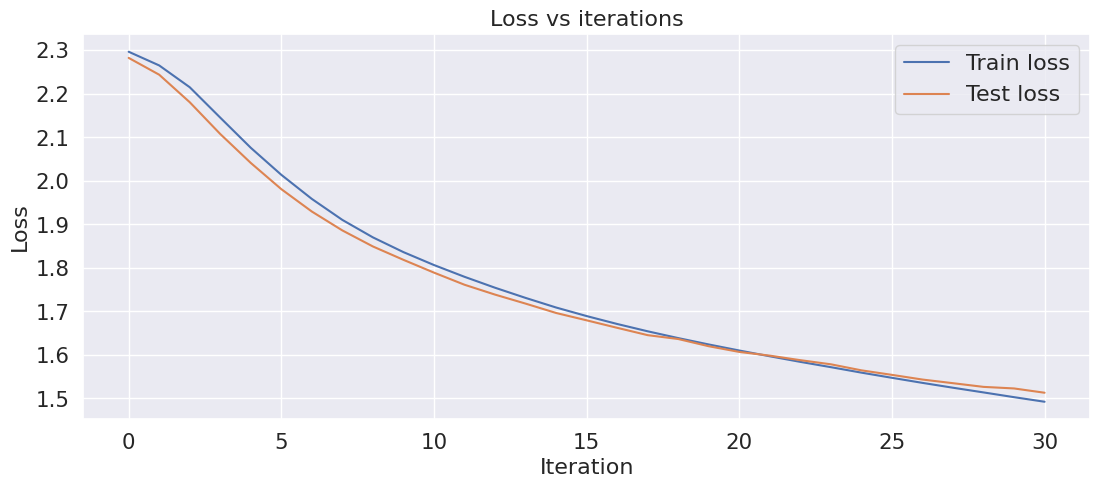

In [63]:
losses = {"Train loss": train_losses, "Test loss": test_losses}
plot_losses(losses)

In [64]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1),
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))
  return confusion_matrix

def test(model, dataloader, classes):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  # again no gradients needed
  with torch.no_grad():
      for images, labels in dataloader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1

  # print accuracy for each class
  total_correct = 0.0
  total_prediction = 0.0
  for classname, correct_count in correct_pred.items():
      total_correct += correct_count
      total_prediction += total_pred[classname]
      accuracy = 100 * float(correct_count) / total_pred[classname]
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))

In [65]:
confusion_matrix = evaluate_accuracy(model, test_loader, CATEGORIES)

Accuracy for class airplane is: 53.0 %
Accuracy for class automobile is: 62.0 %
Accuracy for class bird  is: 33.1 %
Accuracy for class cat   is: 32.2 %
Accuracy for class deer  is: 31.0 %
Accuracy for class dog   is: 34.0 %
Accuracy for class frog  is: 56.4 %
Accuracy for class horse is: 52.7 %
Accuracy for class ship  is: 65.2 %
Accuracy for class truck is: 46.9 %
Global acccuracy is 46.6


In [66]:
import seaborn as sn
# Confira: https://seaborn.pydata.org/generated/seaborn.heatmap.html
# Aprenda a interpretar heatmaps: https://youtu.be/kEQAY4gcSd0

<Axes: >

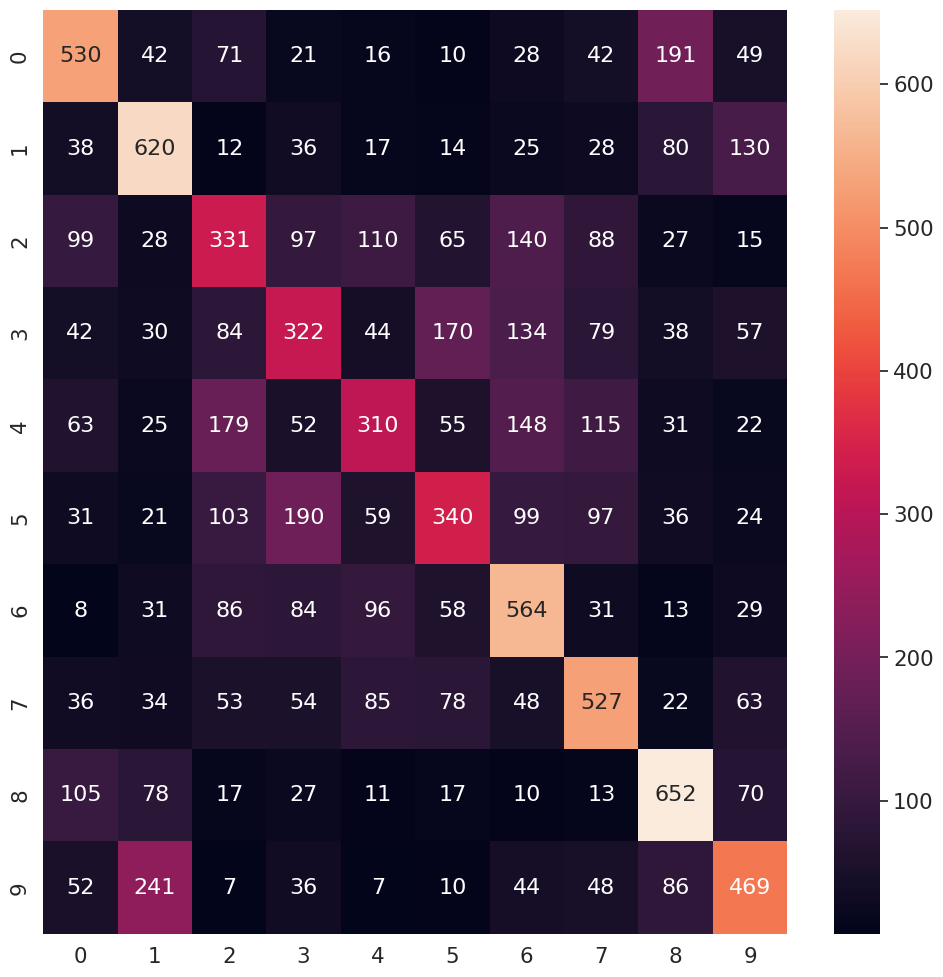

In [67]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d')

# Redes neurais convulacionais

In [40]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
      super().__init__()
      self.convlayers = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(16, 32, kernel_size=(3, 3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

      )

      self.linearlayers = nn.Sequential(
          nn.Linear(1152, 256),
          nn.ReLU(),
          nn.Linear(256, 10)
      )

  def forward(self, x):
      x = self.convlayers(x)
      x = torch.flatten(x, 1)
      return self.linearlayers(x)

In [41]:
convmodel = ConvolutionalModel().to(device)

In [42]:
conv_optimizer = torch.optim.SGD(convmodel.parameters(), lr=0.001)
convlossfunc = nn.CrossEntropyLoss()

In [43]:
epochs = 31
conv_train_losses = []
conv_test_losses = []
for t in range(epochs):
  train_loss = train(convmodel, train_loader, convlossfunc, conv_optimizer)
  conv_train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  test_loss = validate(convmodel, test_loader, convlossfunc)
  conv_test_losses.append(test_loss)

Epoch: 0; Train Loss: 2.2775123445579157
Epoch: 10; Train Loss: 1.6917576222773403
Epoch: 20; Train Loss: 1.4366160922343163
Epoch: 30; Train Loss: 1.3063119596532544


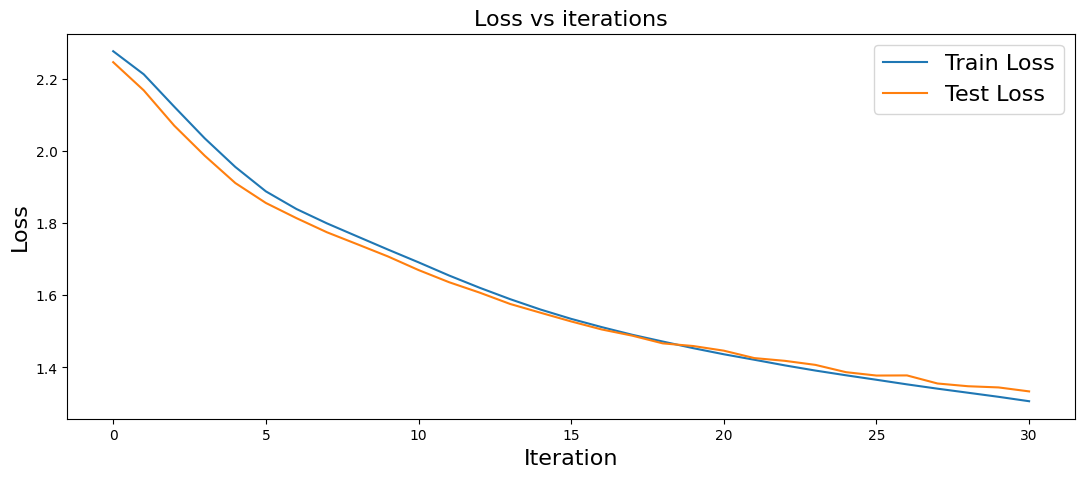

In [50]:
conv_losses = {"Train Loss": conv_train_losses, "Test Loss": conv_test_losses}
plot_losses(conv_losses)

In [57]:
conv_confusion_matrix = evaluate_accuracy(convmodel, test_loader, CATEGORIES)

Accuracy for class airplane is: 54.4 %
Accuracy for class automobile is: 61.8 %
Accuracy for class bird  is: 36.9 %
Accuracy for class cat   is: 26.4 %
Accuracy for class deer  is: 40.3 %
Accuracy for class dog   is: 41.6 %
Accuracy for class frog  is: 71.9 %
Accuracy for class horse is: 65.4 %
Accuracy for class ship  is: 71.7 %
Accuracy for class truck is: 55.9 %
Global acccuracy is 52.6


<Axes: >

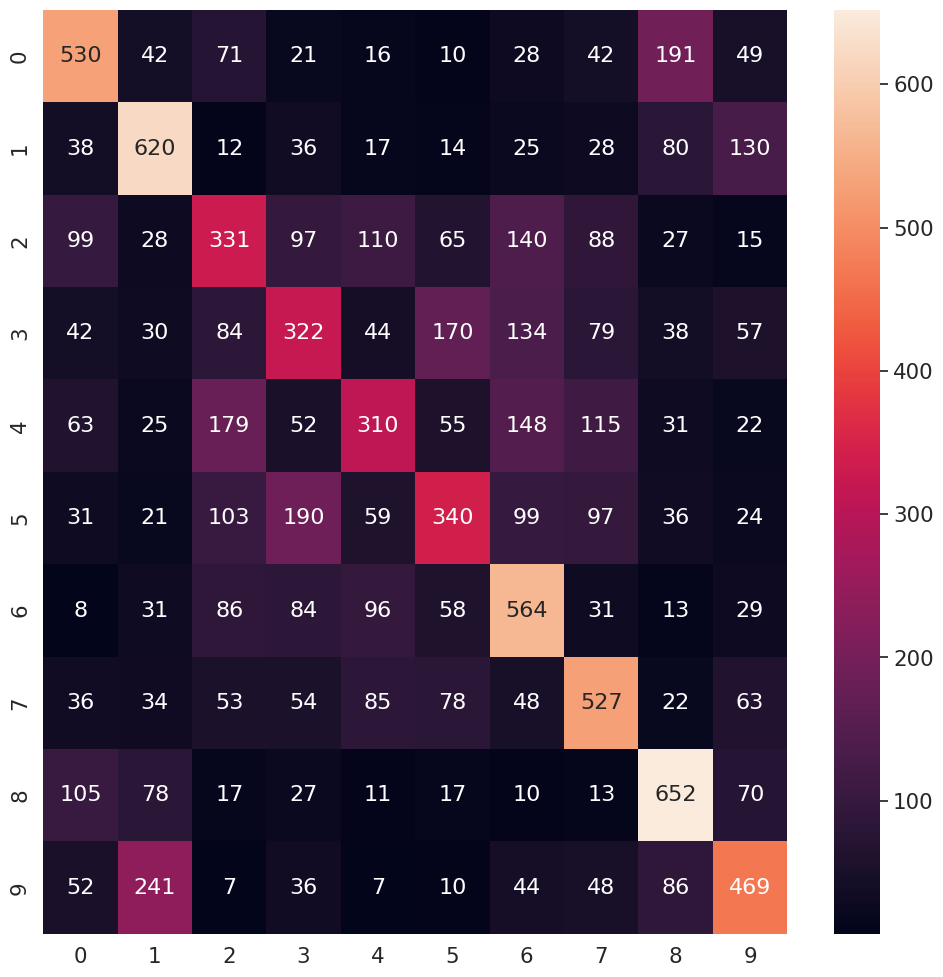

In [68]:
plt.figure(figsize=(12, 12))
sn.set(font_scale=1.4)
sn.heatmap(confusion_matrix.tolist(),
           annot=True, annot_kws={"size": 16}, fmt='d')

In [69]:
from PIL import Image

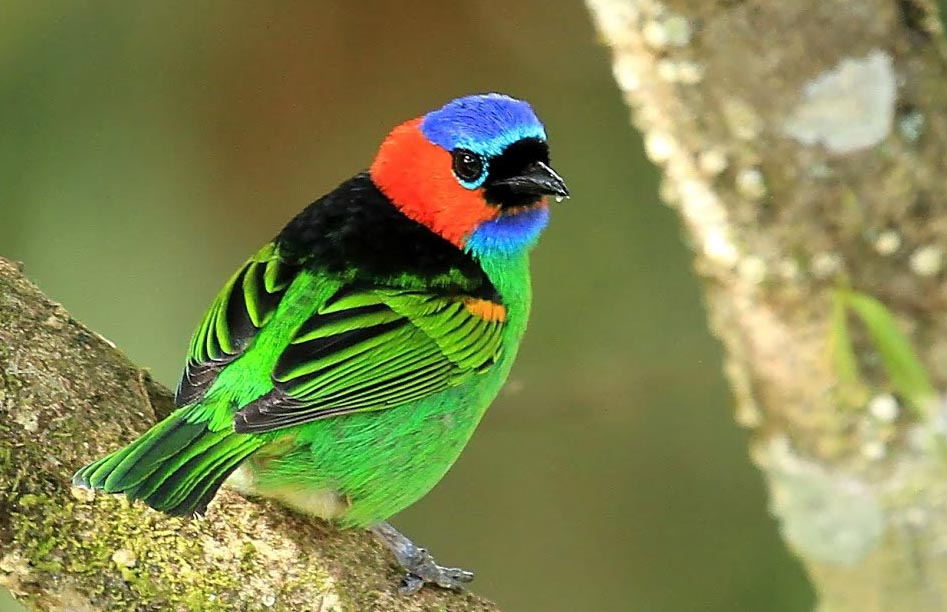

In [119]:
img = Image.open(get_path('/content/drive/MyDrive/datasets/cifar10/passaro.jpg'))
img

In [120]:
prep_transforms = T.Compose(
    [T.Resize((32, 32)),
     T.ToTensor(),
     T.Normalize( (0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616) )
     ]
)
img_tensor = prep_transforms(img)

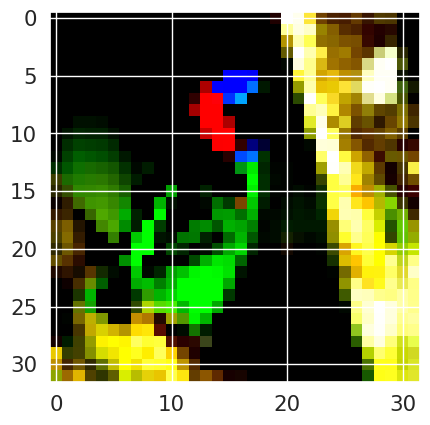

In [121]:
plt.imshow(img_tensor.permute(1,2,0))

In [122]:
batch = img_tensor.unsqueeze(0).to(device)

In [123]:
convmodel.eval()

ConvolutionalModel(
  (convlayers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [124]:
output = convmodel(batch)
output

tensor([[-1.5938, -5.1965,  4.6521,  1.8100,  2.7180,  2.4896,  0.7442,  2.3759,
         -5.5205, -3.7378]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [125]:
logits = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}
for i, classname in enumerate(CATEGORIES):
  prob = logits[0][i].item()
  print(f"{classname} score: {prob:.2f}")
  prob_dict[classname] = [prob]


airplane score: 0.13
automobile score: 0.00
bird score: 69.30
cat score: 4.04
deer score: 10.02
dog score: 7.97
frog score: 1.39
horse score: 7.12
ship score: 0.00
truck score: 0.02


In [107]:
import pandas as pd

In [126]:
df_prob = pd.DataFrame.from_dict(prob_dict)

<Axes: >

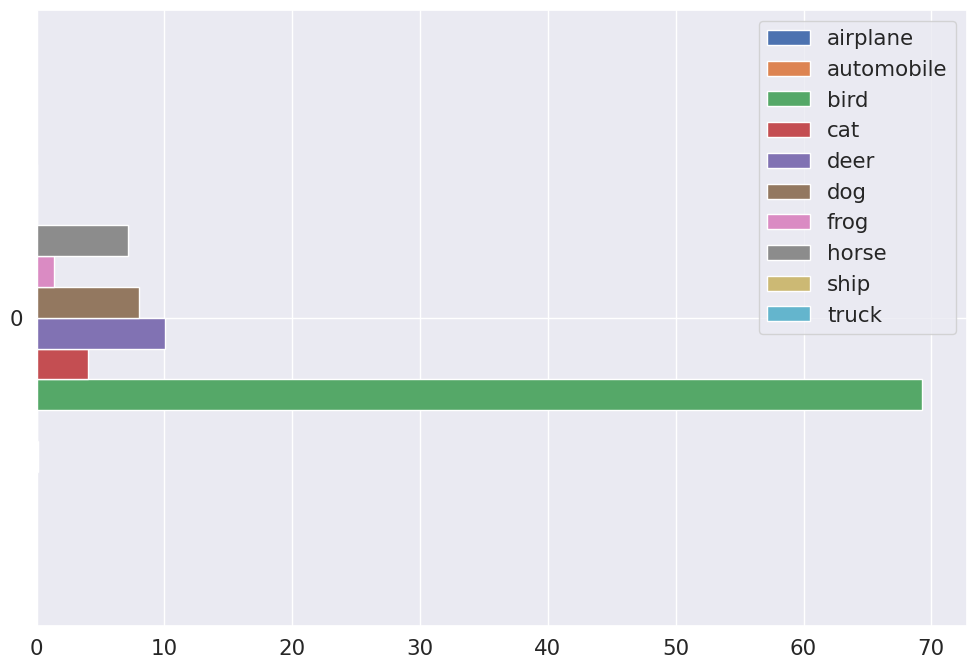

In [127]:
df_prob.plot(kind='barh', figsize=(12, 8))